We often get questions about how to relate atoms in the products of a chemical reaction to the corresponding atoms in the reactants which were provided to the reaction. The RDKit provides a couple of pieces of information that can help here; this post shows how to access that information and what it means.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2025.03.3


This is the reaction definition `Niementowski_quinazoline` from the SI of the paper "A Collection of Robust Organic Synthesis Reactions for In Silico Molecule Design" by [Hartenfeller et al. ](http://pubs.acs.org/doi/abs/10.1021/ci200379p).

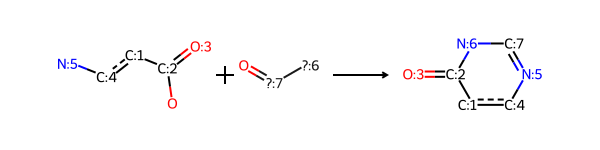

In [2]:
rxn = rdChemReactions.ReactionFromSmarts('[c:1](-[C;$(C-c1ccccc1):2](=[OD1:3])-[OH1]):[c:4](-[NH2:5]).[N;!H0;!$(N-N);!$(N-C=N);!$(N(-C=O)-C=O):6]-[C;H1,$(C-[#6]):7]=[OD1]>>[c:4]2:[c:1]-[C:2](=[O:3])-[N:6]-[C:7]=[N:5]-2')
rxn

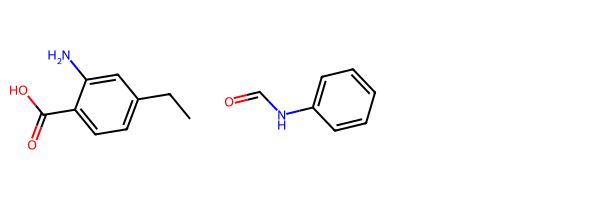

In [3]:
reactants = [Chem.MolFromSmiles(x) for x in ('c1c(C(=O)O)c(N)cc(CC)c1', 'C(=O)Nc1ccccc1')]
Draw.MolsToGridImage(reactants)

In [4]:
prods = rxn.RunReactants(reactants)
len(prods)

1

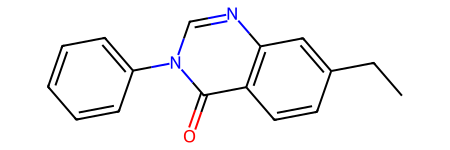

In [5]:
prods[0][0]

In [6]:
prods[0][0].GetAtomWithIdx(0).GetPropsAsDict(includeComputed=False)

{'old_mapno': 4, 'react_atom_idx': 5, 'react_idx': 0}

`old_mapno` is the atom map number of the atom in the product template, `react_idx` is the index of the reactant that the atom came from (this was added in release 2024.09.6, so it won't be there in older releases), and `react_atom_idx` is the index of the atom in that reactant.

Here's an atom that wasn't in the product template, so it doesn't have an atom map number:

In [7]:
prods[0][0].GetAtomWithIdx(10).GetPropsAsDict(includeComputed=False)

{'react_atom_idx': 7, 'react_idx': 0}

Here's a sample function that draws a product molecule and highlights atoms and bonds based upon which reactant they came from. It can also optionally include the original atom indices.

In [8]:
from IPython.display import SVG

def draw_mol_highlighted_by_atom_origin(mol,
                                        includeOriginalAtomIndices=True,
                                        size=(450,450),
                                        colors=[(1,1,0.67),(1,0.8,0.6),(1., .71, .76),(.8, 1., .8)],
                                       ):
    # copy the molecule since we will modify it:
    mol = Chem.Mol(mol)
    if not mol.GetNumConformers():
        rdDepictor.Compute2DCoords(mol)
        rdDepictor.StraightenDepiction(mol)
    atom_highlights = {}
    bond_highlights = {}
    rads = {}
    mults = {}

    for at in mol.GetAtoms():
        pd = at.GetPropsAsDict()
        if 'react_idx' in pd:
            atom_highlights[at.GetIdx()] = [colors[pd['react_idx']]]
            rads[at.GetIdx()] = 0.4
            mults[at.GetIdx()] = 1
        if includeOriginalAtomIndices and 'react_atom_idx' in pd:
            at.SetProp('atomNote',str(pd['react_atom_idx']))
    for bnd in mol.GetBonds():
        bidx = bnd.GetBeginAtomIdx()
        eidx = bnd.GetEndAtomIdx()
        if bidx in atom_highlights and eidx in atom_highlights and atom_highlights[bidx] == atom_highlights[eidx]:
            bond_highlights[bnd.GetIdx()] = atom_highlights[bidx]
    d2d = Draw.MolDraw2DSVG(size[0],size[1])
    d2d.DrawMoleculeWithHighlights(mol,'',atom_highlights,bond_highlights,rads,mults)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

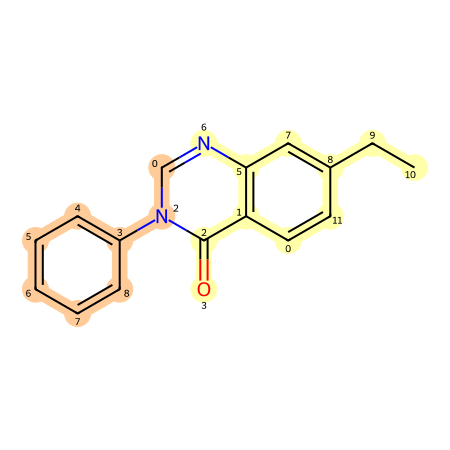

In [9]:
mol = prods[0][0]
SVG(draw_mol_highlighted_by_atom_origin(mol))

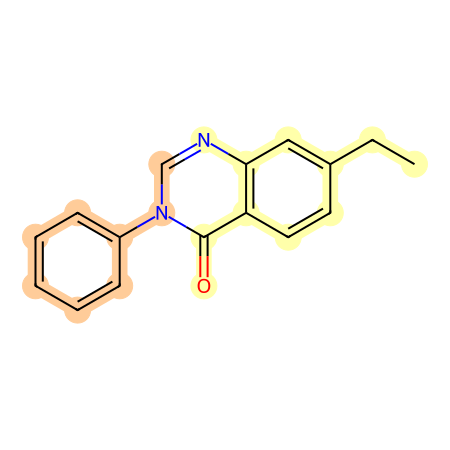

In [10]:
SVG(draw_mol_highlighted_by_atom_origin(mol,includeOriginalAtomIndices=False))